In [1]:
%reload_ext autoreload
%autoreload 2

## Algoritmos Evolutivos 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

### Trabajo Final

### 5º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |

## MSTGAM-4trading

### 1. DESCRIPCIÓN DEL DESAFÍO

Se presenta la implementación de un **sistema de trading algorítmico** optimizado mediante un **Algoritmo Genético (GA)**, diseñado específicamente para la agregación y priorización de recomendaciones procedentes de múltiples estrategias de trading basadas en el paradigma de *Directional Changes* (DC) con distintos umbrales de detección de cambios direccionales.

El objetivo principal es desarrollar un marco de decisión robusto capaz de generar señales óptimas de inversión (buy, sell o hold) en mercados de acciones, combinando de forma inteligente las recomendaciones de ocho estrategias de trading DC-based, cada una perfilada bajo diez umbrales diferentes (θ). Este enfoque multi-estrategia y multi-umbral permite capturar una visión más completa y granular de la dinámica del mercado, superando las limitaciones de los enfoques tradicionales basados en tiempo físico fijo o en un único umbral DC. El Algoritmo Genético propuesto optimiza los pesos y prioridades de las sub-estrategias individuales, resolviendo conflictos entre señales contradictorias y maximizando el rendimiento ajustado al riesgo sin requerir suposiciones previas sobre el comportamiento del mercado.

### 2. IMPLEMENTACIÓN

#### 2.2 LIBRERÍAS

In [2]:
import matplotlib.pyplot as plt
from main import DCTrader

#### 2.3 MODEL DEFINITION

In [3]:
ticker = 'AAPL'

start_train = '2020-01-01'
end_train = '2024-01-01'

start_test = '2024-01-02'
end_test = '2025-01-01'

# Crear
trader = DCTrader(ticker, 
                  start_date=start_train, 
                  end_date=end_train, 
                  is_train=True)

Loading data for AAPL...
AAPL: 1006 loaded days | 2020-01-02 to 2023-12-29
Precomputation of signals completed.
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)


#### 2.3.1 ENTRENAMIENTO

Se emplea la clase `GATrainer`, que implementa un **algoritmo genético (GA) basado en la biblioteca DEAP** para optimizar los pesos del modelo ensemble de estrategias (`DCEnsembleModel`).

**Representación del individuo (cromosoma)**

- Cada individuo es un vector de valores reales (lista de `float`).
- La longitud del vector es igual a `model.n_weights`, que corresponde al número total de parámetros/pesos del ensemble (combinaciones de estrategia + threshold).
- **Inicialización**: valores distribuidos uniformemente en el intervalo `[0.0, 1.0]`.
- Durante la evolución, la mutación gaussiana puede llevar los valores fuera de este rango.
- **Restricción post-mutación**: se aplica una transformación suave mediante la función `np.tanh` para mapear los valores al intervalo **(-1, 1)**:

  ```python
  for ind in offspring:
      for i in range(len(ind)):
          ind[i] = np.tanh(ind[i])  # Mapeo suave a (-1, 1)
  ```

MarkdownEsto permite pesos negativos (interpretables como **inversión de señales débiles o de bajo rendimiento**) mientras evita valores extremos descontrolados que podrían desestabilizar el ensemble.

**Función de fitness**

La evaluación se realiza en el método `_evaluate` y busca maximizar un **Sharpe Ratio ajustado** con la siguiente lógica:
  ```python
  fitness = SR

  if RoR > 0:
      fitness += 0.1 * min(RoR, 1.0)
  ```

**Métricas utilizadas**

- **SR**: Sharpe Ratio diario.
- **RoR**: Rate of Return.
- **ToR**: Turnover Rate (actualmente sin penalización activa).
- **Trades**: número total de operaciones.
- **STD_daily**: volatilidad diaria (para detectar estrategias sin riesgo).

**Objetivo**: maximizar el Sharpe Ratio premiando rentabilidades positivas y evitando soluciones con muy pocas operaciones o volatilidad nula.

**Operadores evolutivos**

- **Inicialización**: uniforme en `[0, 1]`.
- **Crossover**: Blend crossover (`tools.cxBlend`, α = 0.5) con probabilidad `cxpb = 0.60`.
- **Mutación**: Gaussiana (`tools.mutGaussian`, μ = 0.0, σ = 0.2, `indpb = 0.30`).
- **Transformación post-mutación**: aplicación de `np.tanh` para restringir a (-1, 1).
- **Selección**: torneo (`tools.selTournament`, `tournsize = 2`).
- **Reemplazo**: generacional con elitismo mediante `tools.HallOfFame` (preserva siempre al mejor individuo).

**Proceso de entrenamiento**

1. Se crea una población inicial de tamaño configurable (por defecto **300** individuos).
2. Evaluación inicial de toda la población mediante backtest eficiente (usa señales precomputadas del extractor).
3. Bucle evolutivo:
   - Selección por torneo.
   - Crossover (60% probabilidad).
   - Mutación (30% probabilidad por individuo).
   - Mapeo con `tanh`.
   - Re-evaluación solo de individuos modificados.
   - Actualización de la población y del Hall of Fame.
4. Reporte del fitness del mejor individuo en las generaciones 1, cada 10 y la final.
5. Al finalizar (por defecto **150** generaciones), se asignan los pesos del mejor individuo al modelo con `set_flat_weights`.

**Hiperparámetros por defecto**

| Parámetro   | Valor por defecto | Descripción                                      |
|-------------|-------------------|--------------------------------------------------|
| `pop_size`  | 300               | Tamaño de la población                           |
| `n_gen`     | 150               | Número de generaciones                           |
| `cxpb`      | 0.60              | Probabilidad de crossover                        |
| `mutpb`     | 0.30              | Probabilidad de mutación por individuo           |
| `indpb`     | 0.30              | Probabilidad de mutación por gen                 |
| `tournsize` | 2                 | Tamaño del torneo de selección                   |

In [4]:

trader.train(method='GA', 
            pop_size=300,          # mayor diversidad
            n_gen=150,             # más tiempo para converger
            cxpb=0.7,              # menos explotación vía crossover
            mutpb=0.25,            # más introducción de novedades
            indpb=0.2,             # si aplica mutación por gen
            tournsize=2            # menor presión selectiva
            )

# Guardar el mejor modelo
trader.save_model()

Starting training with GA...
Iniciando entrenamiento GA | Población: 300 | Generaciones: 150
Dimensión de pesos: 70
Gen   1 | Fit: 0.017
Gen  10 | Fit: 1.358
Gen  20 | Fit: 1.888
Gen  30 | Fit: 1.888
Gen  40 | Fit: 1.913
Gen  50 | Fit: 1.964
Gen  60 | Fit: 1.974
Gen  70 | Fit: 2.078
Gen  80 | Fit: 2.078
Gen  90 | Fit: 2.078
Gen 100 | Fit: 2.153
Gen 110 | Fit: 2.153
Gen 120 | Fit: 2.153
Gen 130 | Fit: 2.153
Gen 140 | Fit: 2.153
Gen 150 | Fit: 2.153

Entrenamiento GA completado | Mejor fitness: 2.1532
Pesos óptimos asignados al modelo.
Training completed. Optimal weights assigned to the model.
Running backtest...
Backtest completed → RoR: 259.53% | SR: 2.053 | Trades: 90
Model saved to ../persistency/AAPL_model.pkl


Se observa que la función fitness aumenta conforme se avanza en las generaciones. Se deduce asi que también lo hacen el SR asi como el RoR.

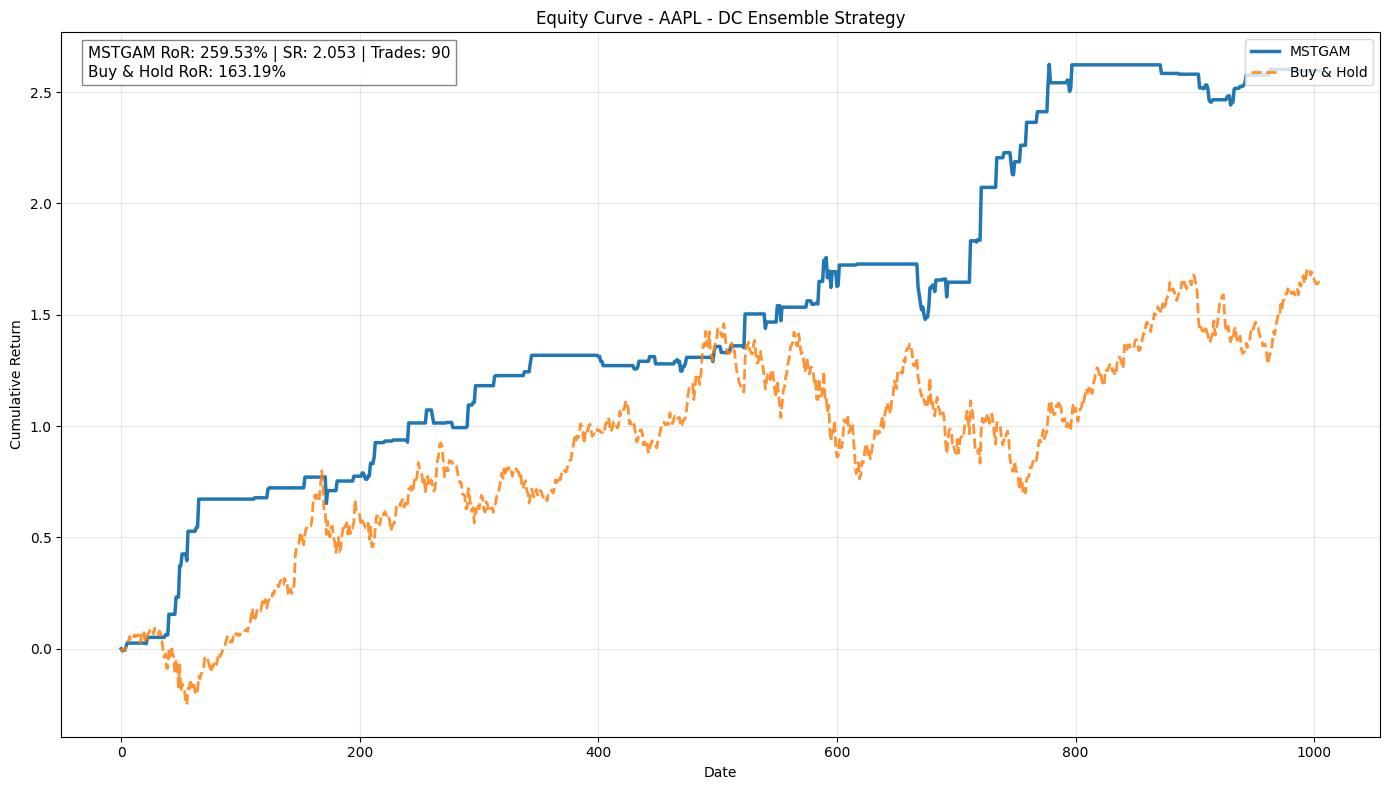

In [5]:
# Ver resultados
trader.plot_equity()

Evaluamos cuales son los pesos de cada par (strategia, threshold). Esto nos permite ver que combinaciones son más eficiente.

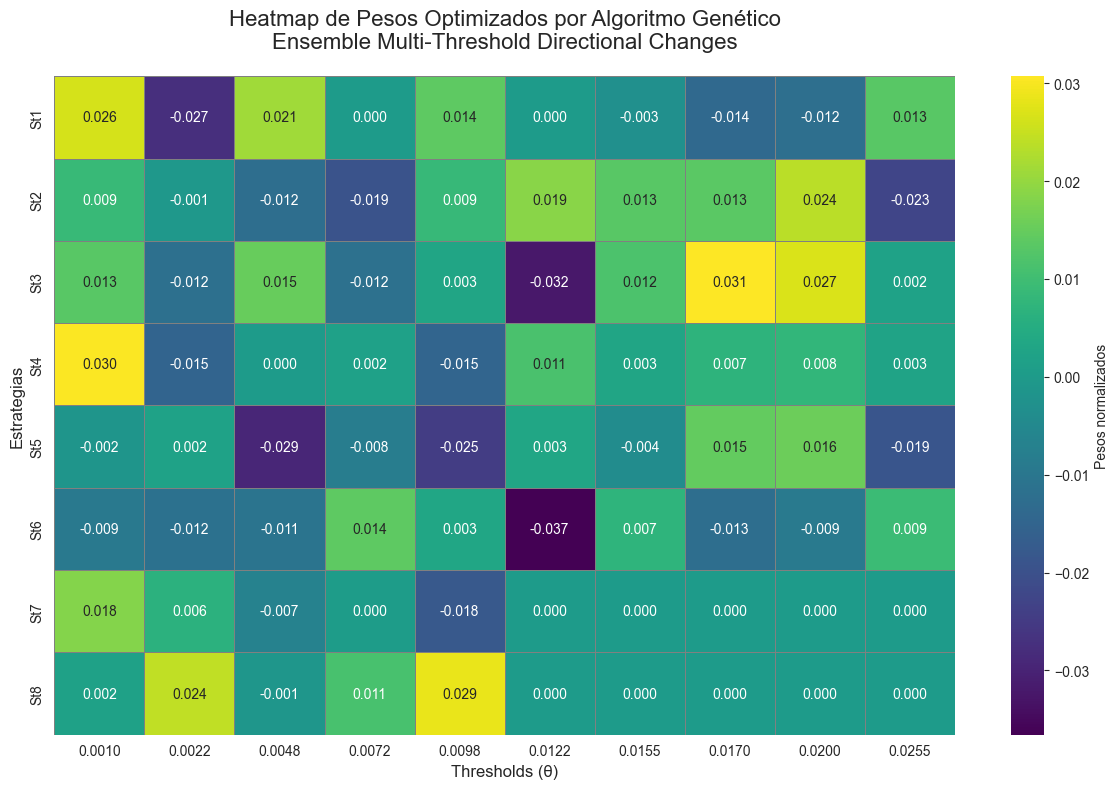

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener la matriz de pesos (n_strats x n_ths)
weights = trader.model.weights  # shape: (8, 10)

# Nombres para los ejes
strategy_names = [f'St{i+1}' for i in range(weights.shape[0])]
threshold_values = [f'{th:.4f}' for th in trader.extractor.thresholds]  # valores reales de theta

# Configuración general de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# =====================================================
# Heatmap de pesos completos
# =====================================================
plt.figure(figsize=(12, 8))
sns.heatmap(
    weights,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Pesos normalizados'},
    xticklabels=threshold_values,
    yticklabels=strategy_names,
    annot_kws={"size": 10}
)

plt.title('Heatmap de Pesos Optimizados por Algoritmo Genético\n'
          'Ensemble Multi-Threshold Directional Changes',
          fontsize=16, pad=20)
plt.xlabel('Thresholds (θ)', fontsize=12)
plt.ylabel('Estrategias', fontsize=12)
plt.tight_layout()
plt.show()

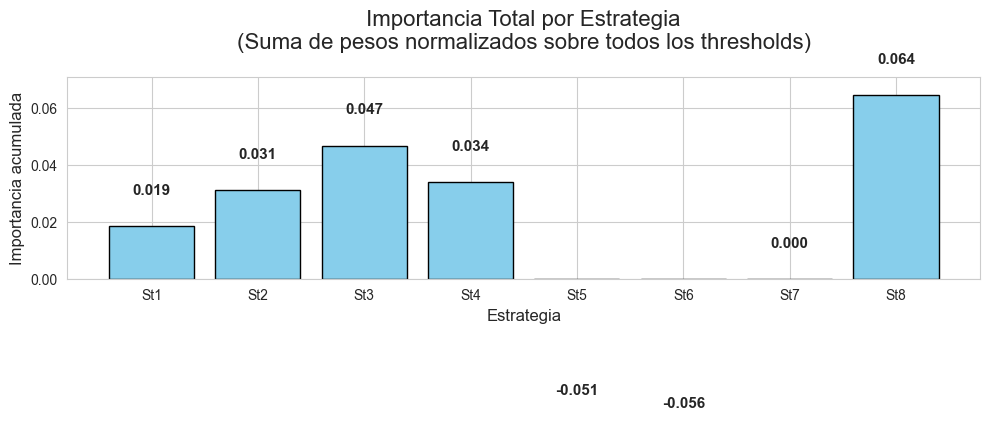

In [7]:
# =====================================================
# Importancia por Estrategia
# =====================================================
strategy_importance = np.sum(weights, axis=1)  # suma por estrategia (sobre todos los thresholds)

plt.figure(figsize=(10, 6))
bars = plt.bar(strategy_names, strategy_importance, color='skyblue', edgecolor='black')

# Añadir valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Importancia Total por Estrategia\n'
          '(Suma de pesos normalizados sobre todos los thresholds)',
          fontsize=16, pad=20)
plt.xlabel('Estrategia', fontsize=12)
plt.ylabel('Importancia acumulada', fontsize=12)
plt.ylim(0, max(strategy_importance) * 1.1)
plt.tight_layout()
plt.show()

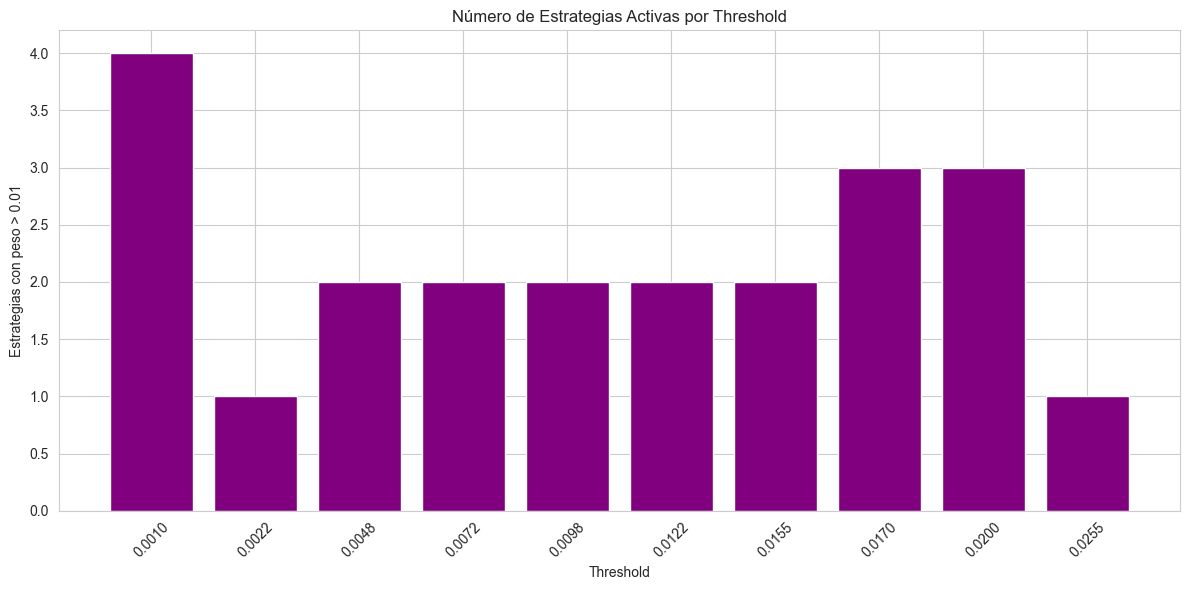

In [8]:
# =====================================================
# Estrategias activas por threshold
# =====================================================

active_strats_per_th = np.sum(weights > 0.01, axis=0)  # umbral pequeño para ruido

plt.figure(figsize=(12, 6))
plt.bar(range(len(threshold_values)), active_strats_per_th, color='purple')
plt.xticks(range(len(threshold_values)), threshold_values, rotation=45)
plt.title('Número de Estrategias Activas por Threshold')
plt.xlabel('Threshold')
plt.ylabel('Estrategias con peso > 0.01')
plt.tight_layout()
plt.show()

In [9]:
# =====================================================
# Tabla resumen de importancia
# =====================================================
print("\n=== RESUMEN DE IMPORTANCIA ===")
print("Estrategias (más → menos importante):")
for name, imp in sorted(zip(strategy_names, strategy_importance), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {imp:.4f}")



=== RESUMEN DE IMPORTANCIA ===
Estrategias (más → menos importante):
  St8: 0.0645
  St3: 0.0468
  St4: 0.0341
  St2: 0.0312
  St1: 0.0187
  St7: 0.0001
  St5: -0.0513
  St6: -0.0561


#### 2.4 EVALUACIÓN

Loading data for AAPL...
AAPL: 1258 loaded days | 2020-01-02 to 2024-12-31
Precomputation of signals completed.
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
Recomputing signals with fixed trained states...
Full model loaded from ../persistency/AAPL_model.pkl
Running backtest...
Backtest completed → RoR: 233.40% | SR: 1.649 | Trades: 107


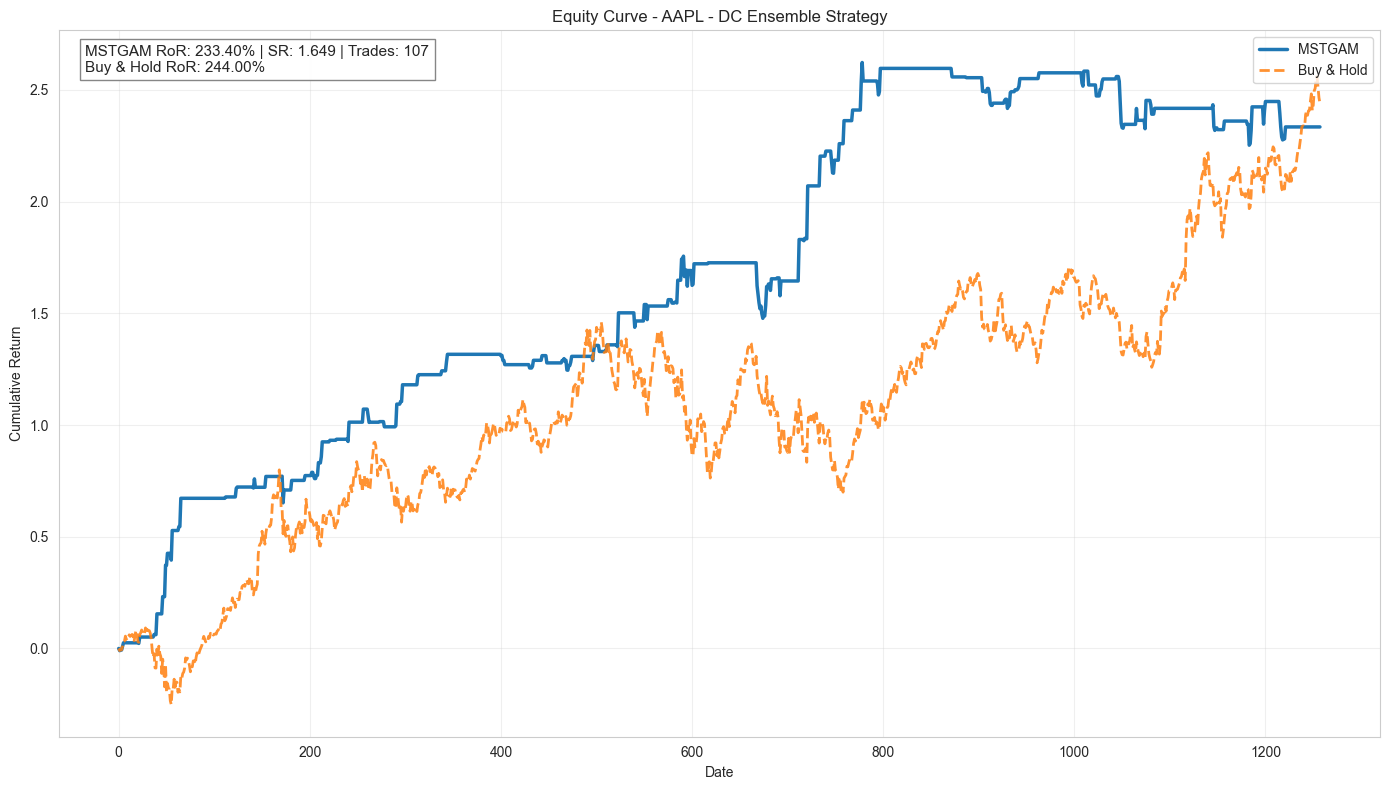

In [17]:
# Cargar el mejor modelo guardado # evaluar en datos de train+test
trader3 = DCTrader(ticker, start_date=start_train, end_date=end_test)
trader3.load_model()
trader3.plot_equity()

Loading data for AAPL...
AAPL: 252 loaded days | 2024-01-02 to 2024-12-31
Precomputation of signals completed.
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
Recomputing signals with fixed trained states...
Full model loaded from ../persistency/AAPL_model.pkl
Running backtest...
Backtest completed → RoR: -6.51% | SR: -0.613 | Trades: 17


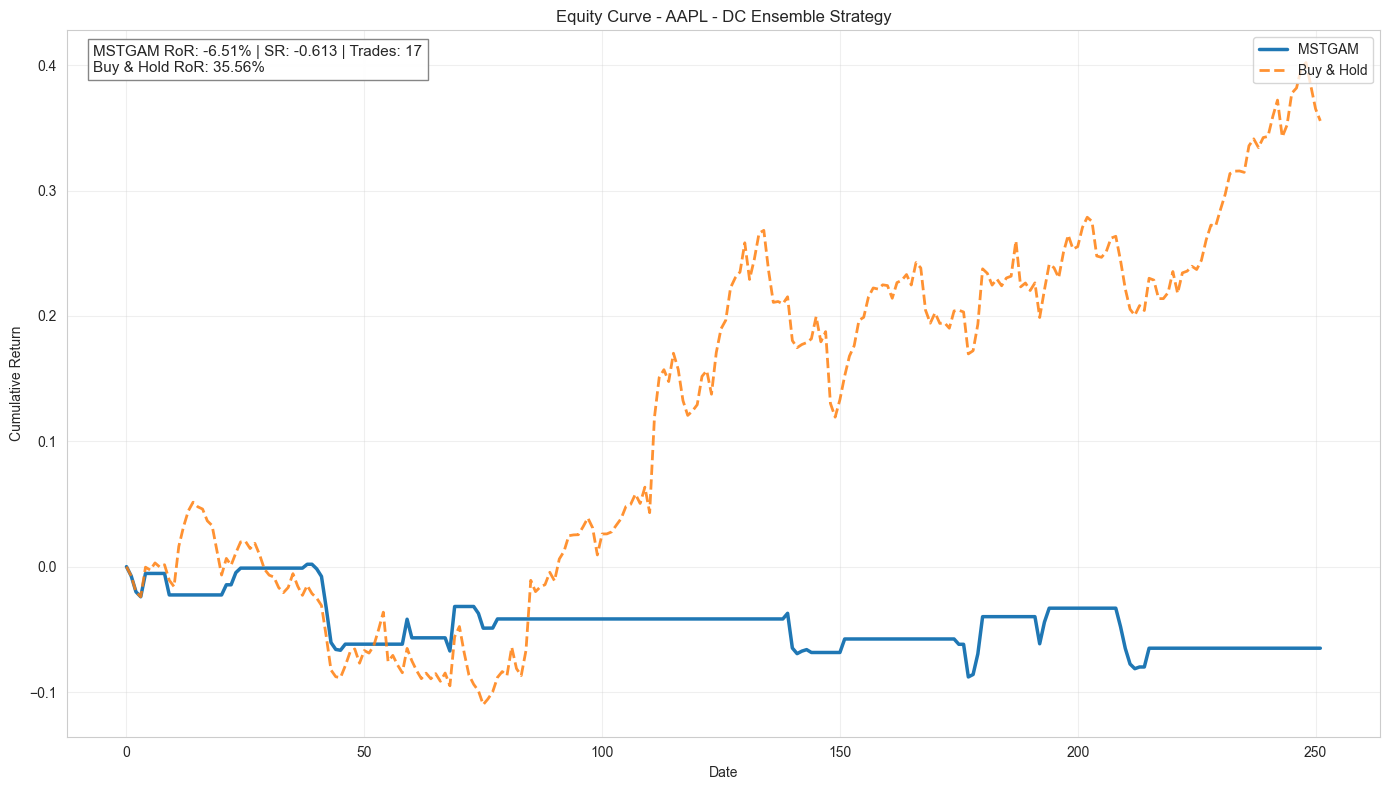

In [ ]:
# Cargar el mejor modelo guardado # evaluar en datos de test
trader4 = DCTrader(ticker, start_date=start_test, end_date=end_test)
trader4.load_model()
trader4.plot_equity()

In [11]:
# Evaluar en datos en vivo (hasta 2025-12-17)

today = '2025-12-17'
trader_live = DCTrader('AAPL', end_date='2025-12-17', is_train=False)
trader_live.load_model()
trader_live.get_latest_recommendation()

Loading data for AAPL...
AAPL: 2554 loaded days | 2015-10-19 to 2025-12-12
Precomputation of signals completed.
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
DCEnsembleModel initialized:
  - Strategies: 8
  - Thresholds: 10
  - Trainable weights: 70 (of 80 possible)
Recomputing signals with fixed trained states...
Full model loaded from ../persistency/AAPL_model.pkl
Running backtest...
Backtest completed → RoR: 156.44% | SR: 0.728 | Trades: 192
Recommention for 2025-12-12: BUY if position=False
Recommention for 2025-12-12: HOLD if position=True


### 3 CONCLUSIONES

- Se presento un enfoque de trading basado en Cambios Direccionales.
- El modelo se basa en el ensamble de la recomendación de diversas estrategias.
- El peso del voto de cada uno se optimzó utilizando algoritmos genéticos con el fin de maximizar el Sharpe Ratio.

#### 3.1 TRABAJOS FUTUROS

1. Optimización conjunta de pesos y thresholds
- Extender el cromosoma del algoritmo genético (GA) para incluir **valores de thresholds dinámicos o adaptativos por estrategia**.
- En lugar de usar un conjunto fijo de 10 thresholds predefinidos, evolucionar simultáneamente un vector de valores θ óptimos (o rangos) junto con los pesos del ensemble.

2. Genetic Programming (GP) para la evolución de nuevas estrategias DC-based
- Sustituir o complementar el GA actual por **Genetic Programming (GP)** para generar automáticamente nuevas reglas de trading a partir de primitivas del paradigma DC (OSV, TMV, rd, rn, patrones históricos, duración de overshoot/DC, etc.).
- Los árboles de GP combinarían indicadores DC existentes con operadores lógicos y aritméticos, permitiendo la creación automática de estrategias St9, St10, etc.

3. Optimización multi-objetivo
- Pasar del objetivo único actual (Sharpe Ratio ajustado) a una formulación **multi-objetivo** que maximice RoR y SR mientras minimiza Drawdown, Turnover Rate (ToR) y VaR simultáneamente.
- Obtener un **frente de Pareto** que ofrezca soluciones con diferentes trade-offs (alto retorno/bajo riesgo vs bajo turnover/alta estabilidad).